In [7]:
import sys
import os

import pandas as pd
import numpy as np
import natsort
import random as rn
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import pyeeg

from scipy import signal
from scipy.signal import (welch, medfilt, wiener,savgol_filter)
from scipy.integrate import simps

import matplotlib.pyplot as plt

#Keras

#Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
from sklearn.svm import (SVC, SVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (StratifiedKFold, KFold)

from sklearn.metrics import (accuracy_score, make_scorer, balanced_accuracy_score, roc_auc_score, mean_squared_error)

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.metrics import confusion_matrix

from pystruct.models import ChainCRF
from pystruct.learners import FrankWolfeSSVM
from pystruct.learners import OneSlackSSVM

from sklearn.ensemble import VotingClassifier

from statistics import median
seed=42
np.random.seed(seed)
rn.seed(seed)
tf.set_random_seed(seed)
dir_path = os.getcwd()
# https://en.wikipedia.org/wiki/Neural_oscillation
SAMPLE_PER_SEC = 128
SAMPLE_PER_RAT = 21600
DELTA_WAVE = [1, 4]
THETA_WAVE = [4, 8]
ALPHA_WAVE = [7.5, 12.5]
BETA_WAVE = [13, 30]
TOTAL_ENERGY = [0, 64]
# not used
LOW_GAMMA_WAVE = [30, 70]
HIGH_GAMMA_WAVE = [70, 150]

EPSILON =  0.0002
FILTER_WINDOW = 5

# Function defintions

In [12]:
def get_train_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path, csv_file)
    print(f"Reading {csv_file}")
    with open(csv_file, 'r') as csvfile:
        train_reader = pd.read_csv(csvfile)
        train_reader.drop(labels="Id", axis=1, inplace=True)
        
        
    return train_reader.values

def get_target_from_csv(csv_file):
    '''
    get a numpy array y of labels. the order follows the id of 4 second sample. 
    argument: relative path to the csv_file from the source folder.
    '''
    csv_file = os.path.join(dir_path,csv_file)
    with open(csv_file, 'r') as csvfile:
        label_reader = pd.read_csv(csvfile)
        #print("Labels: ", label_reader['id'])
        y = label_reader['y']
        
    y = np.array(y)
    return y

def get_features_emg(X):
    all_featues = []
    for i in tqdm(range(X.shape[0])):
        features = list()
        # https://ieeexplore.ieee.org/document/7748960
        x_i = X[i,:]
        # Root Mean Square (RMS): RMS of EMG
        features.append(mean_squared_error(x_i, np.zeros(x_i.shape)))
        
        #Integrated Absolute Value (IAV)
        features.append(np.sum(np.abs(x_i)))
        
        # Mean Absolute Value (MAV): MAV feature can be expressed as
        features.append(np.mean(x_i))
        
        # TBD:
        # Modified Mean Absolute Value type 1
        # Modified Mean Absolute Value type 2
        
        # Simple Square Integral (SSI): SSI is calculated as
        features.append(np.sum(x_i ** 2))
        
        # Variance (VAR): VAR is calculated as
        features.append(np.var(x_i))
        
        #The 3rd, 4th and 5th temporal moments
        features.append(np.mean(x_i ** 3))
        features.append(np.mean(x_i ** 4))
        features.append(np.mean(x_i ** 5))
        
        # TBD
        # v-Order 
        
        # Waveform Length
        features.append(np.sum(np.abs(np.diff(x_i))))
        
        # Average Amplitude Change
        features.append(np.mean(np.abs(np.diff(x_i))))
        
        # Difference Absolute Standard Deviation Value
        features.append(np.sqrt(np.mean(np.power(np.diff(x_i), 2))))
        
        # AX BASIC FEATUERS
        features.append(np.std(x_i))
        features.append(np.min(x_i))
        features.append(np.max(x_i))
        features.append(np.sum(np.abs(x_i) > EPSILON))
        
        
        
        all_featues.append(features)
    return np.array(all_featues)

def get_features_eeg(X):
    all_featues = []
    # NOT SURE ABOUT THIS VALUES 
    # LETS DOUBLE CHECK
    K_MAX = 6
    SAMPLE_PER_SEC = 32
    FREQ_BANDS = list(range(16))
    TAU = 16
    # embedding dimension
    DE = 32
    
    for i in tqdm(range(X.shape[0])):
        features = list()
        # http://pyeeg.sourceforge.net/
        x_i = X[i,:]
        
        # Power Spectral Intensity (PSI) and Relative Intensity Ratio (RIR)	bin_power()	Two 1-D vectors
        
        
        # Petrosian Fractal Dimension (PFD)	pdf()	A scalar
        features.append(pyeeg.pfd(x_i))
        
        # Higuchi Fractal Dimension (HFD)	hfd()	A scalar
        features.append(pyeeg.hfd(x_i, K_MAX))
        
        # Hjorth mobility and complexity	hjorth()	Two scalars
        
        # Spectral Entropy (Shannon's entropy of RIRs)	spectral_entropy()	A scalar
        #features.append(pyeeg.spectral_entropy(x_i, FREQ_BANDS, SAMPLE_PER_SEC))
        
        # SVD Entropy	svd_entropy()	A scalar
        #features.append(pyeeg.svd_entropy(x_i, TAU, DE))
        
        # Fisher Information	fisher_info()	A scalar
        features.append(pyeeg.fisher_info(x_i, TAU, DE))
          
        # Detrended Fluctuation Analysis (DFA)	dfa()	A scalar
        features.append(pyeeg.dfa(x_i))
        
        # Hurst Exponent (Hurst)	hurst()	A scalar
        #features.append(pyeeg.hurst(x_i))
        
        # AX BASIC FEATUERS
        features.append(np.mean(x_i))
        features.append(np.std(x_i))
        features.append(np.min(x_i))
        features.append(np.max(x_i))
        features.append(np.sum(np.abs(x_i) > EPSILON))
        
        """
            DELTA_WAVE = [1, 4]
            THETA_WAVE = [4, 8]
            ALPHA_WAVE = [7.5, 12.5]
            BETA_WAVE = [13, 30]
        """
        delta = bandpower(x_i, DELTA_WAVE)
        theta = bandpower(x_i, THETA_WAVE)
        alpha = bandpower(x_i, ALPHA_WAVE)
        beta = bandpower(x_i, BETA_WAVE)
        total_energy = bandpower(x_i, TOTAL_ENERGY)
        
        
        features.append(delta)
        features.append(theta)
        features.append(alpha)
        features.append(beta)
        
        
        features.append(delta / total_energy)
        features.append(theta / total_energy)
        features.append(alpha / total_energy)
        features.append(beta / total_energy)
        
        
        
        all_featues.append(features)
    return np.array(all_featues)


def get_data_of_rat(X, y, i):
    sample_cnt = int(X.shape[0] / 3)
    if i == 0:
        return X[:sample_cnt, :], y[:sample_cnt]
    if i == 1:
        return X[sample_cnt: 2 * sample_cnt, :], y[sample_cnt: 2 * sample_cnt]
    if i == 2:
        return X[2 * sample_cnt:, :], y[2 * sample_cnt:]
    
    
def bandpower(data, band, window_sec=4, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.

    Examples
    ------
    1. Absolute and relative power in the delta band
        >>> delta = bandpower(data, 100, [0.5, 4])
        >>> delta_relative = bandpower(data, 100, [0.5, 4], relative=True)

    2. Delta / beta ratio
        >>> window_sec = 4
        >>> delta = bandpower(data, 100, [0.5, 4], window_sec)
        >>> beta = bandpower(data, 100, [12, 30], window_sec)
        >>> db_ratio = delta / beta
    """
    
    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if window_sec is not None:
        nperseg = window_sec * SAMPLE_PER_SEC
    else:
        nperseg = (2 / low) * SAMPLE_PER_SEC

    freqs, psd = welch(data, SAMPLE_PER_SEC, nperseg=nperseg, scaling='density')

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs < high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], freqs[idx_band])

    if relative:
        bp /= simps(psd, freqs)
    return bp

def remove_impossible_transitions(y_pred):
    last = y_pred[0]
    cnt = 0
    for i in range(1, y_pred.shape[0]):
        cur = y_pred[i]
        if last == 1 and cur == 3:
            y_pred[i - 1] = 2
            #break
        last = cur
    return y_pred

from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss
def check_for_floats(Array):
    for row in Array:
        for el in row:
            if isinstance(el, float):
                print(el)
                
def from_label_to_vec(labels):
    labels_vec = []
    for l in labels:
        if l == 1:
            labels_vec.append([1,0,0])
        elif l == 2:
            labels_vec.append([0,1,0])
        elif l == 3:
            labels_vec.append([0,0,1])
    return np.array(labels_vec)

                
def from_vec_to_labels(vecs):
    labels = []
    for v in vecs:
        if v[0] == 1:
            labels.append(1)
        elif v[1] == 1:
            labels.append(2)
        elif v[2] == 1:
            labels.append(3)
    return labels
  
def count_labels(labels):
    classes_cnt = [0,0,0]
    for l in labels:
        classes_cnt[l-1]+=1
    print(classes_cnt)

# Load the train and test data

In [5]:
# train
train_emg = os.path.join(dir_path,"data/train/train_emg.csv")
train_eeg_1 = os.path.join(dir_path,"data/train/train_eeg1.csv")
train_eeg_2 = os.path.join(dir_path,"data/train/train_eeg2.csv")

# trest
test_emg = os.path.join(dir_path,"data/test/test_emg.csv")
test_eeg_1 = os.path.join(dir_path,"data/test/test_eeg1.csv")
test_eeg_2 = os.path.join(dir_path,"data/test/test_eeg2.csv")

# labels
train_target = os.path.join(dir_path,'data/train/train_labels.csv')

x_train_emg = get_train_from_csv(train_emg) #List of numpy arrays
x_train_eeg_1 = get_train_from_csv(train_eeg_1) #List of numpy arrays
x_train_eeg_2 = get_train_from_csv(train_eeg_2) #List of numpy arrays
y_train = get_target_from_csv(train_target) #Numpy array of labels

x_test_emg = get_train_from_csv(test_emg) #List of numpy arrays
x_test_eeg_1 = get_train_from_csv(test_eeg_1) #List of numpy arrays
x_test_eeg_2 = get_train_from_csv(test_eeg_2) #List of numpy arrays

print(f"Class 1: {np.sum(y_train == 1)}")
print(f"Class 2: {np.sum(y_train == 2)}")
print(f"Class 3: {np.sum(y_train == 3)}")

Reading /home/ax/master/2018_02/ml/task5/data/train/train_emg.csv
Reading /home/ax/master/2018_02/ml/task5/data/train/train_eeg1.csv
Reading /home/ax/master/2018_02/ml/task5/data/train/train_eeg2.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_emg.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_eeg1.csv
Reading /home/ax/master/2018_02/ml/task5/data/test/test_eeg2.csv
Class 1: 34114
Class 2: 27133
Class 3: 3553


# Compute features

In [8]:
print("Computing features for training set ..")
x_train_emg_feat = get_features_emg(x_train_emg)
x_train_eeg_1_feat = get_features_eeg(x_train_eeg_1)
x_train_eeg_2_feat = get_features_eeg(x_train_eeg_2)

print("Computing features for test set ..")
x_test_emg_feat = get_features_emg(x_test_emg)
x_test_eeg_1_feat = get_features_eeg(x_test_eeg_1)
x_test_eeg_2_feat = get_features_eeg(x_test_eeg_2)

print("TRAIN")
print(x_train_eeg_1_feat.shape)
print(x_train_eeg_2_feat.shape)
print(x_train_emg_feat.shape)

print("TEST")
print(x_test_eeg_1_feat.shape)
print(x_test_eeg_2_feat.shape)
print(x_test_emg_feat.shape)

X_train = np.concatenate((x_train_emg_feat,x_train_eeg_1_feat,x_train_eeg_2_feat), axis = 1)
print("X train final shape -> ",X_train.shape)

X_test = np.concatenate((x_test_emg_feat,x_test_eeg_1_feat,x_test_eeg_2_feat), axis = 1)
print("X test final shape -> ",X_test.shape)

Computing features for training set ..



Computing features for test set ..



TRAIN
(64800, 17)
(64800, 17)
(64800, 15)
TEST
(43200, 17)
(43200, 17)
(43200, 15)
X train final shape ->  (64800, 49)
X test final shape ->  (43200, 49)


# Scale the data

In [9]:
X_total = np.concatenate((X_train, X_test))
print("X total shape -> ", X_total.shape)

scaler = StandardScaler().fit(X_total)

data_dim = X_train.shape[1]
timesteps = SAMPLE_PER_RAT
num_classes = 3
batch_size = 32

X total shape ->  (108000, 49)


# Create model, train and do final prediction

Running LSTM...
  start fold
  start fold
  start fold
LSTM unique predictions [1. 2. 3.]
Starting CRF...
CRF unique predictions [1. 2. 3.]
Running SVC...
SVC unique predictions [1. 2. 3.]
Starting Voting Filtered...


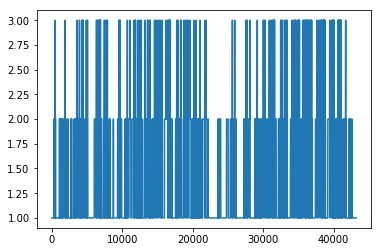

In [13]:

# LSTM
print("Running LSTM...")
kfold = KFold(n_splits=3, shuffle=False, random_state=seed)
EPOCHS=20
classes = np.array([1,2,3])
weights = compute_class_weight("balanced", classes, y_train)
cw = dict(zip(np.array([0,1,2]), weights))
lstm_predictions = []


X_test_scaled = scaler.transform(X_test)
X_test_scaled_lstm = np.reshape(X_test_scaled, (2 * timesteps, 1, data_dim))

for train, valid in kfold.split(X_train):
    print("  start fold")
    X_train_fold = X_train[train]
    y_train_fold = y_train[train]
    
    X_valid_fold = X_train[valid]
    y_valid_fold = y_train[valid]

    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_valid_fold_scaled = scaler.transform(X_valid_fold)
    
    
    X_train_fold_scaled_lstm = np.reshape(X_train_fold_scaled, (2 * timesteps, 1, data_dim))
    y_train_fold_lstm = from_label_to_vec(y_train_fold)
    
    X_valid_fold_scaled_lstm= np.reshape(X_valid_fold_scaled, (timesteps, 1, data_dim))
    y_valid_fold_lstm = from_label_to_vec(y_valid_fold)


    model = Sequential()
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, stateful=True, batch_input_shape=(batch_size, 1, data_dim)))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, stateful=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, stateful=True))
    model.add(Dense(num_classes, activation='softmax'))
    

    model.compile(loss=weighted_categorical_crossentropy(weights),
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    model.fit(X_train_fold_scaled_lstm, y_train_fold_lstm,
              class_weight=cw,
              verbose=0,
              batch_size=batch_size, epochs=EPOCHS, shuffle=False,
              validation_data=(X_valid_fold_scaled_lstm, y_valid_fold_lstm))
    
    
    
    y_pred_lstm = model.predict(X_test_scaled_lstm)
     
    lstm_predictions.append(y_pred_lstm)

    
y_pred_lstm = (lstm_predictions[0] + lstm_predictions[1] + lstm_predictions[2])/3.0
labels = []
for p in y_pred_lstm:
    labels.append(np.argmax(p)+1)
    y_pred_lstm = np.array(labels)   
    
y_pred_filtered_lstm = medfilt(y_pred_lstm, FILTER_WINDOW)

print(f"LSTM unique predictions {np.unique(y_pred_filtered_lstm)}")

# CRF

print("Starting CRF...")
classes = np.array([1,2,3])
weights_crf = compute_class_weight("balanced", classes, y_train)
weights_crf[0] = weights_crf[0]+2.5
weights_crf[1] = weights_crf[1]+1.5

X_train_crf = X_train.reshape(3, -1, 49)
y_train_crf = y_train.reshape(3,-1) -1
    
X_test_crf = X_test.reshape(2, -1, 49)

model = ChainCRF(class_weight=weights_crf)
ssvm = OneSlackSSVM(model=model, C=0.1, max_iter=2000)
    
ssvm.fit(X_train_crf, y_train_crf)   
   
y_pred_crf = ssvm.predict(X_test_crf)
y_pred_crf = np.asarray(y_pred_crf).reshape(-1) + 1  
y_pred_filtered_crf = medfilt(y_pred_crf, FILTER_WINDOW)


print(f"CRF unique predictions {np.unique(y_pred_filtered_crf)}")


# SVC
print("Running SVC...")
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC(class_weight="balanced", random_state=seed, C=0.01, verbose=False, gamma=0.0004)
svc.fit(X_train_scaled, y_train)

y_pred_svc = svc.predict(X_test_scaled)      
y_pred_filtered_svc = medfilt(y_pred_svc, FILTER_WINDOW)

print(f"SVC unique predictions {np.unique(y_pred_filtered_svc)}")


# Voting
print("Starting Voting Filtered...")
y_pred_filtered_voting = np.array([])
for i in range(0,y_pred_filtered_crf.shape[0]):
    y_pred_filtered_voting = np.append(y_pred_filtered_voting, median([y_pred_filtered_svc[i],  y_pred_filtered_lstm[i], y_pred_filtered_crf[i]]))
y_pred_filtered_voting = medfilt(y_pred_filtered_voting, FILTER_WINDOW)


submission_name = "final.csv"


y_pred_df = pd.DataFrame(y_pred_filtered_voting)
y_pred_df = y_pred_df.assign(Id=list(range(y_pred_filtered_voting.shape[0])))
y_pred_df.columns = ['y', 'Id']
y_pred_df["y"].plot()
submission_folder = os.path.join(dir_path,"submissions/")
csv_file = submission_folder + submission_name

with open(csv_file, 'w') as csv:
    y_pred_df.to_csv(csv,index = False)